In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer, RobustScaler, Normalizer
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\henri\OneDrive\Documentos\EDSA\EDS Bootcamp\Project\Data\HR_DS.csv')

In [3]:
# Remove variables with no variability
non_objs = df.describe().columns.tolist()

noneed=0
list_noneed = []

for col in non_objs:
    if df[col].min() == df[col].max():
        df.drop(columns=[col], inplace=True)
        non_objs.remove(col)
        noneed += 1
        list_noneed.append(col)

if noneed == 1: 
    print('The {0} column was droped'.format(list_noneed))
elif noneed > 1:
    print('{0} columns, {1} were droped'.format(noneed, list_noneed))
else:
    print('No columns were removed.')

2 columns, ['EmployeeCount', 'StandardHours'] were droped


In [4]:
# Remove objects with no variation
objects = df.describe(include='O').columns.tolist()

noneed=0
list_noneed = []

for col in objects:
    if len(df[col].unique()) == 1:
        df.drop(columns=[col], inplace=True)
        objects.remove(col)
        noneed += 1
        list_noneed.append(col)

if noneed == 1: 
    print('The {0} column was droped.'.format(list_noneed))
elif noneed > 1:
    print('{0} columns, {1} were droped.'.format(noneed, list_noneed))
else:
    print('No columns were removed.')

The ['Over18'] column was droped.


In [5]:
patterns = [' ', 'Travel_', '-', '&']
for p in patterns:
    df[objects] = df[objects].apply(lambda x: x.str.replace(p, ''))
    print('Pattern "{}" cleared.'.format(p))

Pattern " " cleared.
Pattern "Travel_" cleared.
Pattern "-" cleared.
Pattern "&" cleared.


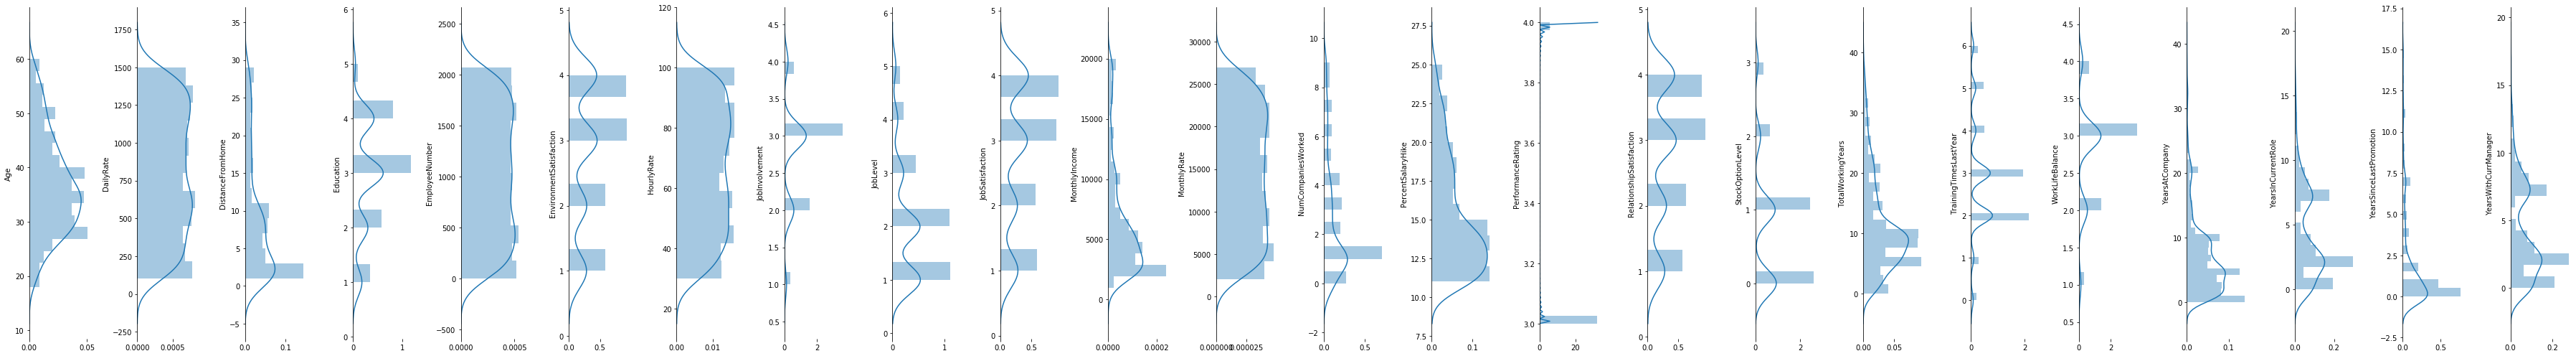

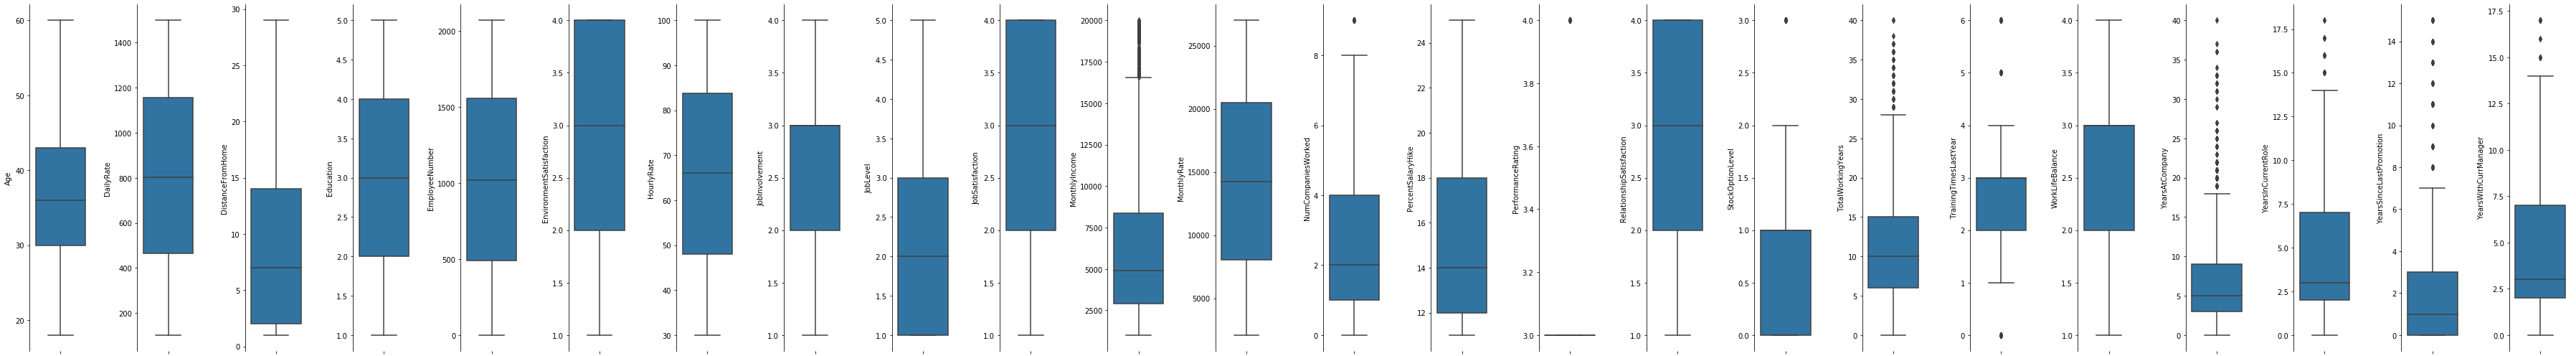

In [6]:
fig, axes = plt.subplots(ncols=len(non_objs), figsize=(50,7))
for ax, col in zip(axes, df[non_objs]):
    sb.distplot(df[col], ax=ax, vertical=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
plt.show()

fig, axes = plt.subplots(ncols=len(non_objs), figsize=(50,7))
for ax, col in zip(axes, df[non_objs]):
    sb.boxplot(df[col], ax=ax, orient='v')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
plt.show()

In [7]:
minmax = MinMaxScaler()
df_pre_ss = pd.concat([df[objects], pd.DataFrame(minmax.fit_transform(df[non_objs]), columns=df[non_objs].columns)], axis=1, sort=False)
df_melted_pre_ss = pd.melt(df_pre_ss, id_vars=objects, value_vars=non_objs, var_name="Var_nonObj", value_name="std_values")

In [8]:
objects

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime']

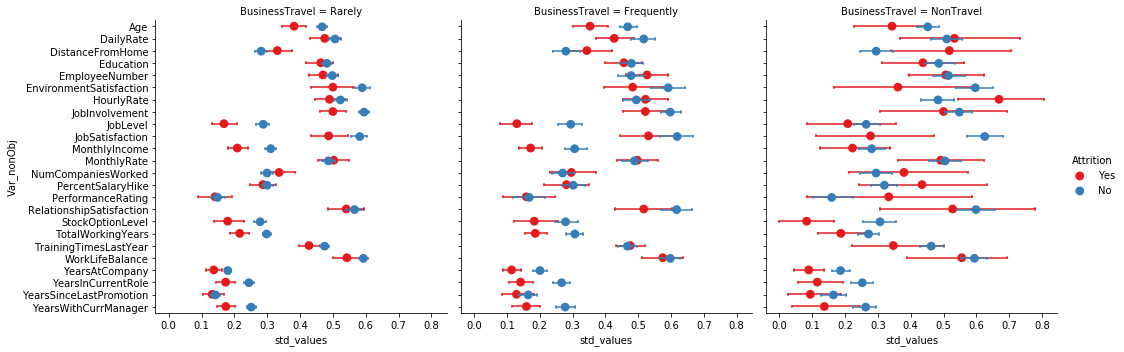

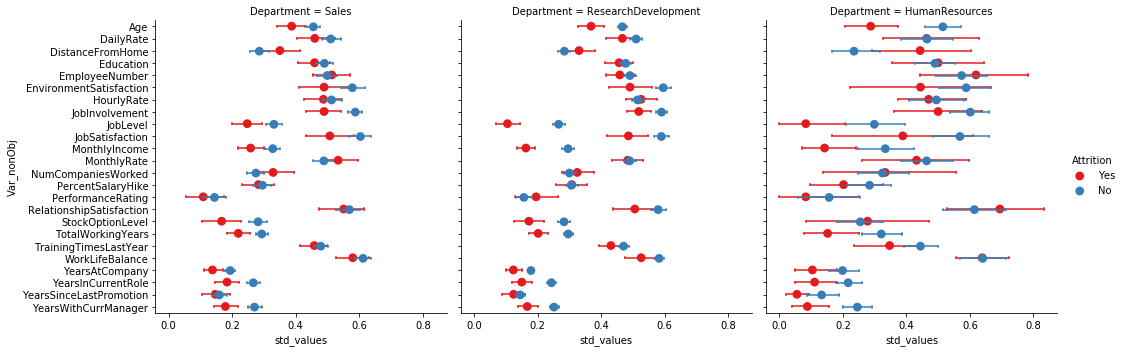

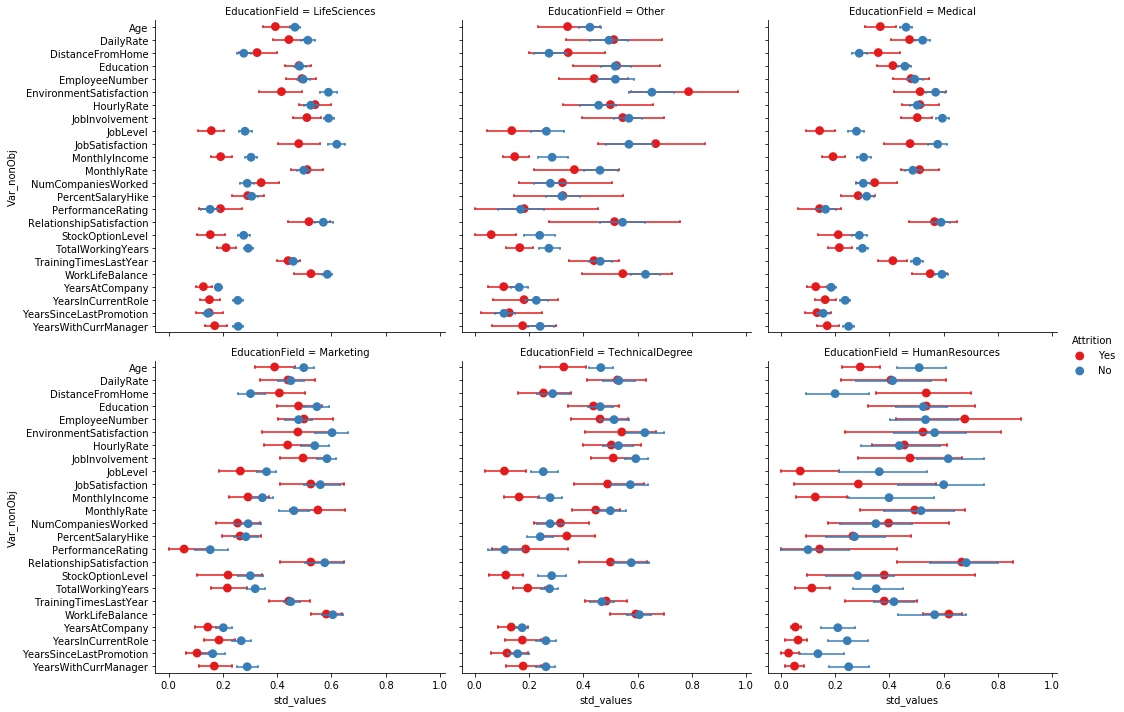

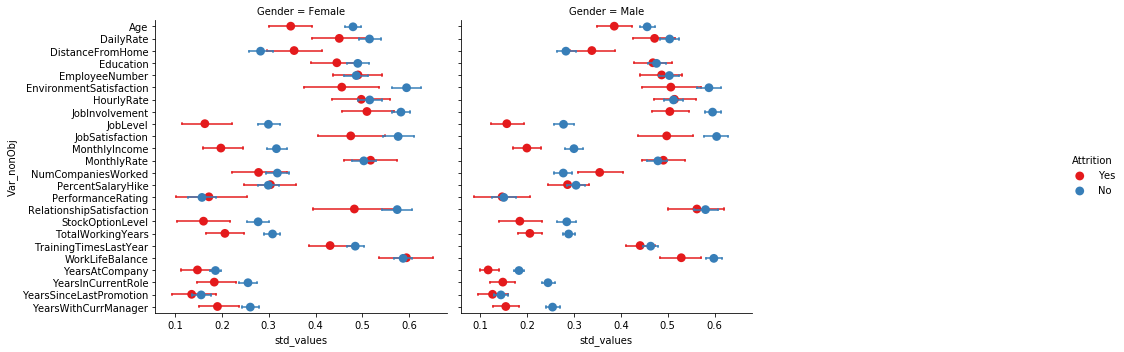

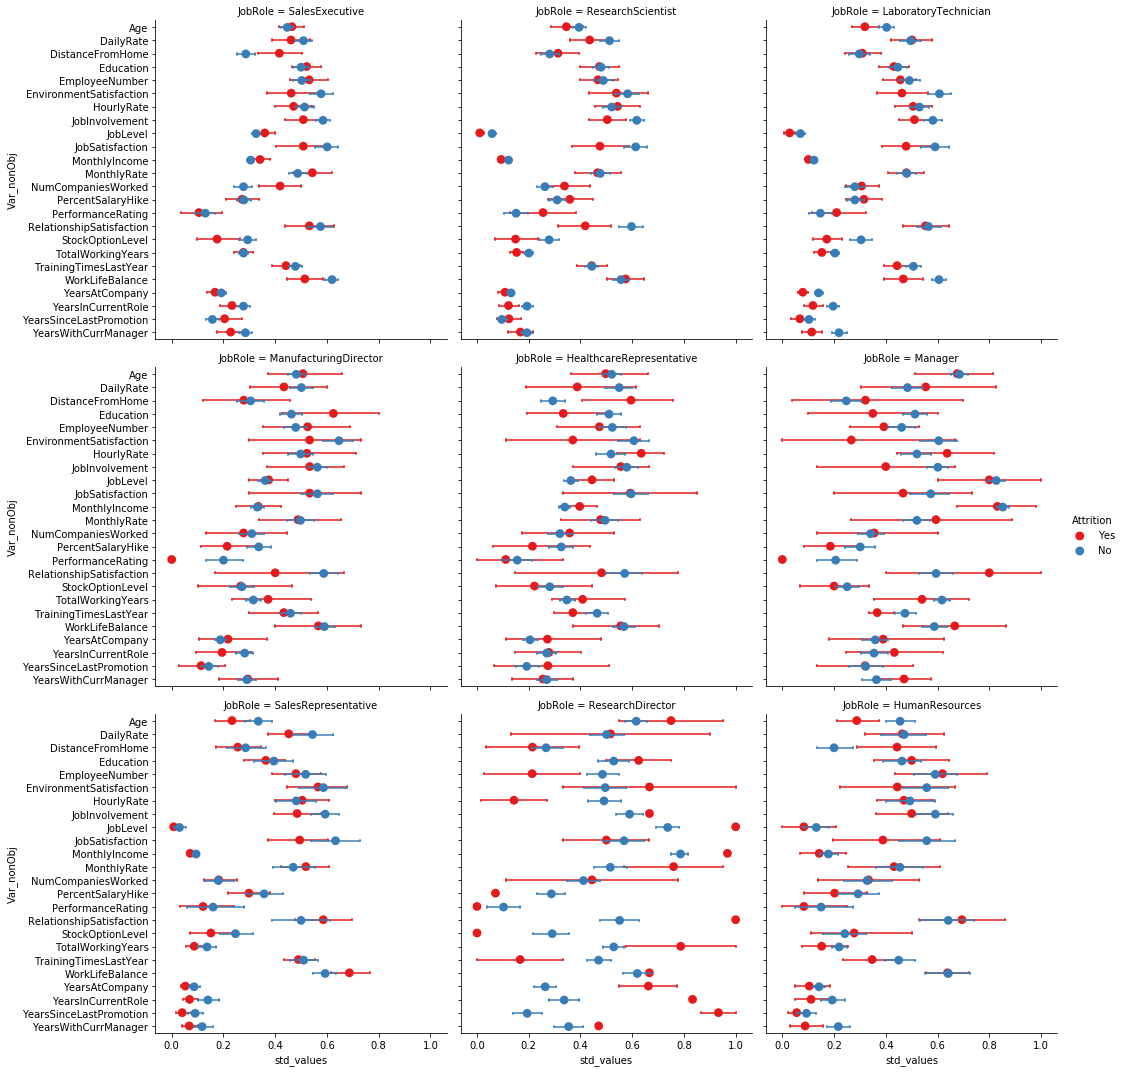

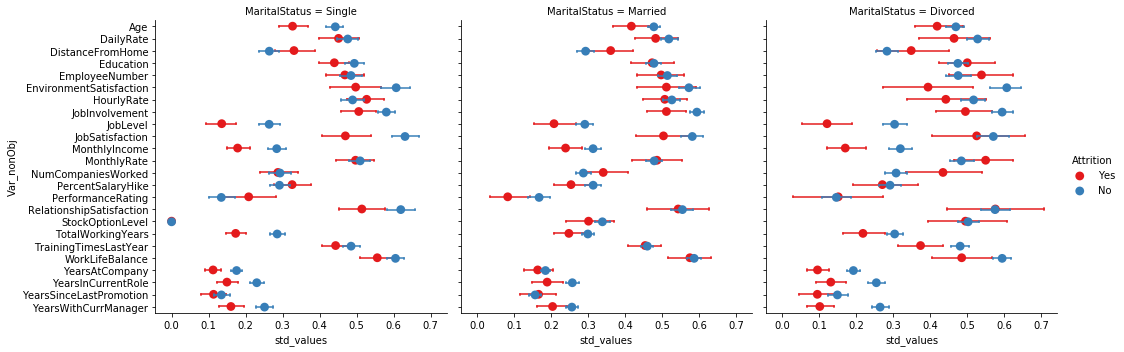

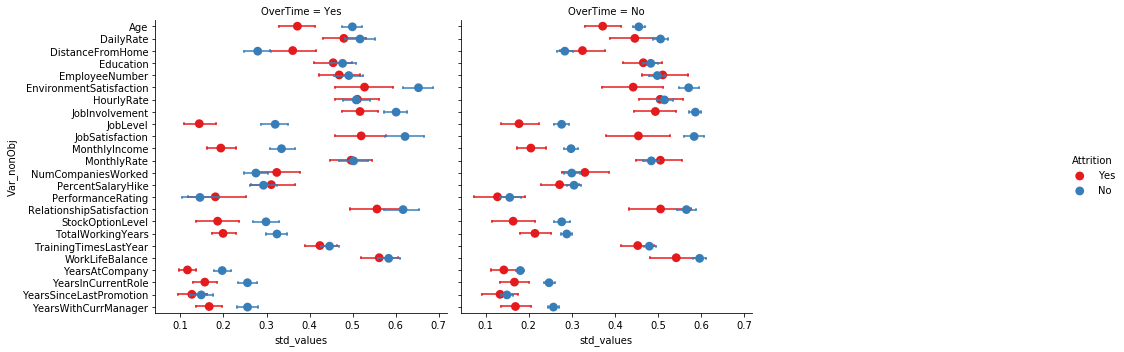

In [9]:
for obj in objects[1:]:
    sb.catplot(x='std_values',
               y='Var_nonObj',
               hue='Attrition',
               data=df_melted_pre_ss, 
               row=None, 
               col=obj, 
               col_wrap=3,
               estimator= np.mean,
               ci=95, 
               n_boot=1000, 
               units=None, 
               order=None, 
               hue_order=None, 
               row_order=None, 
               col_order=None, 
               kind='point', 
               height=5, 
               aspect=1, 
               orient=None, 
               color=None, 
               palette='Set1', 
               legend=True, 
               legend_out=True, 
               sharex=True, 
               sharey=True, 
               margin_titles=True, 
               **{'linestyles':'',
                  'dodge':True,
                  'capsize':0.1,
                  'errwidth':1.5})
    
plt.show()

Making some dummies

In [10]:
df_d = pd.get_dummies(df, drop_first=True)

In [11]:
Norm = MinMaxScaler()

In [12]:
df_d_norm = pd.DataFrame(Norm.fit_transform(df_d), columns=df_d.columns)

In [13]:
df_d_norm.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_NonTravel,BusinessTravel_Rarely,Department_ResearchDevelopment,Department_Sales,EducationField_LifeSciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_TechnicalDegree,Gender_Male,JobRole_HumanResources,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.00000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,0.450567,0.501421,0.292590,0.478231,0.495339,0.573923,0.512731,0.576644,0.265986,0.576190,0.289307,0.490629,0.299244,0.300680,0.153741,0.570748,0.264626,0.28199,0.466553,0.587075,0.175204,0.234958,0.145850,0.242537,0.161224,0.102041,0.709524,0.653741,0.303401,0.412245,0.108163,0.315646,0.055782,0.089796,0.600000,0.035374,0.176190,0.069388,0.098639,0.054422,0.198639,0.221769,0.056463,0.457823,0.319728,0.282993
std,0.217509,0.288840,0.289531,0.256041,0.291255,0.364361,0.290420,0.237187,0.276735,0.367615,0.247918,0.285797,0.277557,0.261424,0.360824,0.360403,0.284026,0.19452,0.214878,0.235492,0.153163,0.201285,0.214829,0.209890,0.367863,0.302805,0.454137,0.475939,0.459884,0.492406,0.310692,0.464931,0.229579,0.285986,0.490065,0.184786,0.381112,0.254199,0.298279,0.226925,0.399112,0.415578,0.230891,0.498387,0.466530,0.450606
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.285714,0.259843,0.035714,0.250000,0.237179,0.333333,0.257143,0.333333,0.000000,0.333333,0.100158,0.239028,0.111111,0.071429,0.000000,0.333333,0.000000,0.15000,0.333333,0.333333,0.075000,0.111111,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.428571,0.501074,0.214286,0.500000,0.493227,0.666667,0.514286,0.666667,0.250000,0.666667,0.205898,0.487513,0.222222,0.214286,0.000000,0.666667,0.333333,0.25000,0.500000,0.666667,0.125000,0.166667,0.066667,0.176471,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.595238,0.755190,0.464286,0.750000,0.752177,1.000000,0.767857,0.666667,0.500000,1.000000,0.388099,0.737503,0.444444,0.500000,0.000000,1.000000,0.333333,0.37500,0.500000,0.666667,0.225000,0.388889,0.200000,0.411765,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000

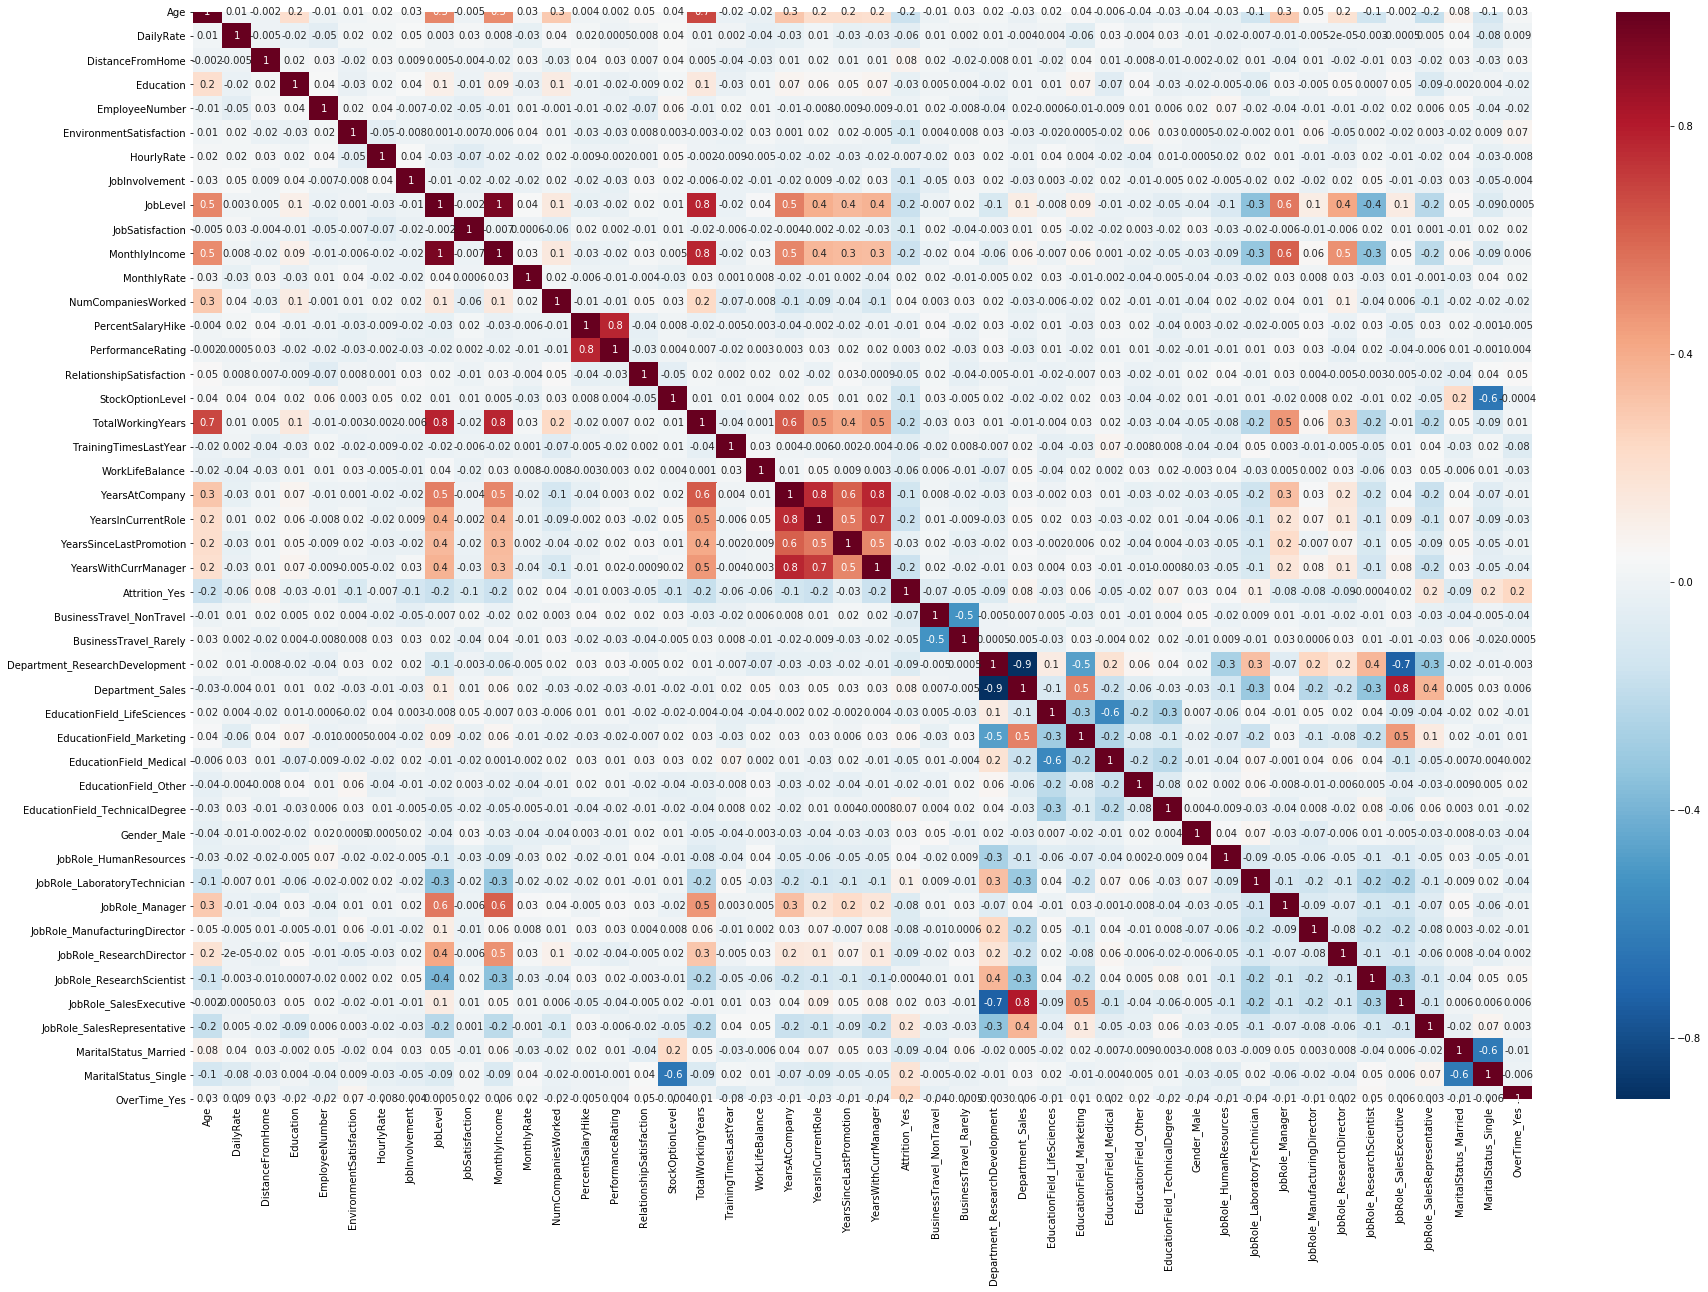

In [14]:
df_d_norm_corr = df_d_norm.corr()
fig = plt.figure(figsize=(30,20))
sb.heatmap(df_d_norm_corr, annot=True, fmt = '.1g', cmap="RdBu_r")
plt.show()

In [15]:
finaldf = pd.get_dummies(df_pre_ss, drop_first=True)

In [16]:
finaldf.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_NonTravel,BusinessTravel_Rarely,Department_ResearchDevelopment,Department_Sales,EducationField_LifeSciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_TechnicalDegree,Gender_Male,JobRole_HumanResources,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.00000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,0.450567,0.501421,0.292590,0.478231,0.495339,0.573923,0.512731,0.576644,0.265986,0.576190,0.289307,0.490629,0.299244,0.300680,0.153741,0.570748,0.264626,0.28199,0.466553,0.587075,0.175204,0.234958,0.145850,0.242537,0.161224,0.102041,0.709524,0.653741,0.303401,0.412245,0.108163,0.315646,0.055782,0.089796,0.600000,0.035374,0.176190,0.069388,0.098639,0.054422,0.198639,0.221769,0.056463,0.457823,0.319728,0.282993
std,0.217509,0.288840,0.289531,0.256041,0.291255,0.364361,0.290420,0.237187,0.276735,0.367615,0.247918,0.285797,0.277557,0.261424,0.360824,0.360403,0.284026,0.19452,0.214878,0.235492,0.153163,0.201285,0.214829,0.209890,0.367863,0.302805,0.454137,0.475939,0.459884,0.492406,0.310692,0.464931,0.229579,0.285986,0.490065,0.184786,0.381112,0.254199,0.298279,0.226925,0.399112,0.415578,0.230891,0.498387,0.466530,0.450606
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.285714,0.259843,0.035714,0.250000,0.237179,0.333333,0.257143,0.333333,0.000000,0.333333,0.100158,0.239028,0.111111,0.071429,0.000000,0.333333,0.000000,0.15000,0.333333,0.333333,0.075000,0.111111,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.428571,0.501074,0.214286,0.500000,0.493227,0.666667,0.514286,0.666667,0.250000,0.666667,0.205898,0.487513,0.222222,0.214286,0.000000,0.666667,0.333333,0.25000,0.500000,0.666667,0.125000,0.166667,0.066667,0.176471,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.595238,0.755190,0.464286,0.750000,0.752177,1.000000,0.767857,0.666667,0.500000,1.000000,0.388099,0.737503,0.444444,0.500000,0.000000,1.000000,0.333333,0.37500,0.500000,0.666667,0.225000,0.388889,0.200000,0.411765,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000

# Models Testing

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [18]:
y = finaldf['Attrition_Yes']
X = finaldf.drop(['Attrition_Yes'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

## 1. Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression as LR

In [20]:
model_logistic = LR(class_weight='balanced',
                     random_state=0,
                     solver='liblinear',
                     max_iter=1000,
                     multi_class='ovr',
                     verbose=True,
                     warm_start=True).fit(x_train, y_train)

[LibLinear]

In [21]:
model_logistic.score(x_test, y_test)

0.7391304347826086

### TODO
Fazer mais visualizações como Confusion Matrix

https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

Fazer a divisão do teste, treino e validaçao com bootstrap ou com método de n combinations

## 2. LinearSVC

In [22]:
from sklearn.svm import LinearSVC as LSVC

In [23]:
model_LinearSVC = LSVC(penalty='l2', 
                       loss='squared_hinge', 
                       dual=False, 
                       tol=0.0001, 
                       C=1.0, 
                       multi_class='ovr', 
                       fit_intercept=True, 
                       intercept_scaling=1, 
                       class_weight='balanced', 
                       verbose=1, 
                       random_state=0, 
                       max_iter=10000).fit(x_train, y_train)

[LibLinear]

In [24]:
model_LinearSVC.score(x_test, y_test)

0.7364130434782609

### TODO
Fazer mais visualizações como Confusion Matrix

Fazer a divisão do teste, treino e validaçao com bootstrap ou com método de n combinations

## 3. SVC

In [25]:
from sklearn.svm import SVC

In [26]:
model_SVC = SVC(C=1.0, 
                kernel='rbf', 
                degree=3, 
                gamma='auto', 
                coef0=0.0, 
                shrinking=True, 
                probability=True, 
                tol=0.001, 
                cache_size=200, 
                max_iter=-1, 
                decision_function_shape='ovr',
                class_weight='balanced',
                verbose=1).fit(x_train, y_train)

[LibSVM]

In [27]:
model_SVC.score(x_test, y_test)

0.779891304347826

### TODO
Fazer mais visualizações como Confusion Matrix

Fazer a divisão do teste, treino e validaçao com bootstrap ou com método de n combinations

## 4. Radius Neighbors Classifier

In [28]:
from sklearn.neighbors import RadiusNeighborsClassifier as RadiusNC

In [29]:
model_RadiusNC = RadiusNC(radius=3,
                          weights='uniform', #distance as a parameter to be used
                          algorithm='auto', #auto, ball_tree, kd_tree, brute
                          leaf_size=30,
                          p=2,
                          metric='minkowski',
                          outlier_label=None, #go deeper... outliers
                          metric_params=None,
                          n_jobs=-1).fit(x_train, y_train)

In [30]:
model_RadiusNC.score(x_test, y_test)

0.8695652173913043

### TODO
Fazer mais visualizações como Confusion Matrix

Fazer a divisão do teste, treino e validaçao com bootstrap ou com método de n combinations

## 5. Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier as RForest

In [32]:
model_RandomForest = RForest(n_estimators=10000, 
                          criterion='gini', 
                          max_depth=None, 
                          min_samples_split=2, 
                          min_samples_leaf=1, 
                          min_weight_fraction_leaf=0.0, 
                          max_features='auto', 
                          max_leaf_nodes=None, 
                          min_impurity_decrease=0.0, 
                          min_impurity_split=None, 
                          bootstrap=True,
                          oob_score=False, 
                          n_jobs=-1, 
                          random_state=0, 
                          verbose=1, 
                          warm_start=False, 
                          class_weight='balanced_subsample').fit(x_train, y_train) #balanced

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 10000 out of

In [33]:
model_RandomForest.score(x_test, y_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 2426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 4026 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 4976 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 6026 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 7176 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 8426 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 9776 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done 10000 out of

0.8885869565217391

### TODO
Fazer mais visualizações como Confusion Matrix

Fazer a divisão do teste, treino e validaçao com bootstrap ou com método de n combinations

## 5. Keras Tensorflow Classification NN

In [34]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl

import os
import tempfile

import sklearn

In [35]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [36]:
neg, pos = np.bincount(finaldf.Attrition_Yes)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1470
    Positive: 237 (16.12% of total)



In [37]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(finaldf, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Attrition_Yes'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Attrition_Yes'))
test_labels = np.array(test_df.pop('Attrition_Yes'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)
print('')
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (940,)
Validation labels shape: (236,)
Test labels shape: (294,)

Training features shape: (940, 45)
Validation features shape: (236, 45)
Test features shape: (294, 45)


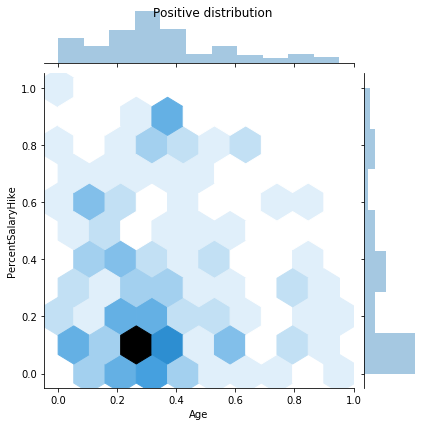

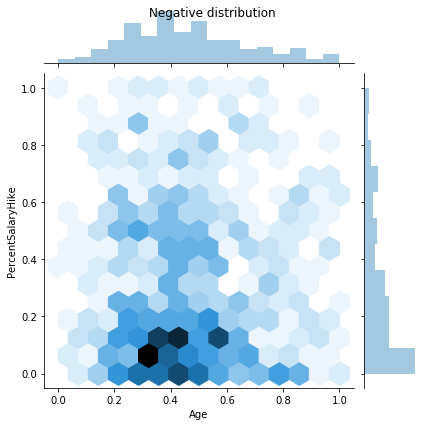

In [38]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

sb.jointplot(pos_df['Age'], pos_df['PercentSalaryHike'],
              kind='hex')
plt.suptitle("Positive distribution")

sb.jointplot(neg_df['Age'], neg_df['PercentSalaryHike'],
              kind='hex')
_ = plt.suptitle("Negative distribution")

In [39]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(8, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [40]:
EPOCHS = 500
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [41]:
model_keras = make_model()
model_keras.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                736       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 881
Trainable params: 881
No

In [42]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model_keras.save_weights(initial_weights)

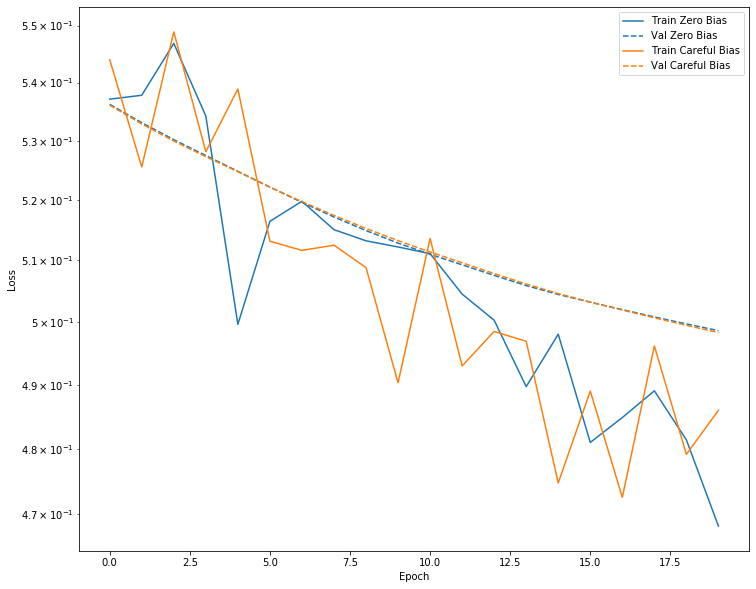

In [43]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [44]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features,
                            train_labels,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            callbacks = [early_stopping],
                            validation_data=(val_features, val_labels))

Train on 940 samples, validate on 236 samples
Epoch 1/500
940/940 [==============================] - 1s 886us/sample - loss: 0.5630 - tp: 9.0000 - fp: 96.0000 - tn: 701.0000 - fn: 134.0000 - accuracy: 0.7553 - precision: 0.0857 - recall: 0.0629 - auc: 0.4045 - val_loss: 0.5362 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 195.0000 - val_fn: 41.0000 - val_accuracy: 0.8263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3432
Epoch 2/500
940/940 [==============================] - 0s 15us/sample - loss: 0.5544 - tp: 6.0000 - fp: 83.0000 - tn: 714.0000 - fn: 137.0000 - accuracy: 0.7660 - precision: 0.0674 - recall: 0.0420 - auc: 0.4155 - val_loss: 0.5331 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 195.0000 - val_fn: 41.0000 - val_accuracy: 0.8263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3486
Epoch 3/500
940/940 [==============================] - 0s 30us/sample - loss: 0.5467 - tp: 8.0000 - fp: 75.0000 - tn: 722.0000 - fn: 135.0000 - a

In [45]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.7,1])
    else:
      plt.ylim([0,1])

    plt.legend()

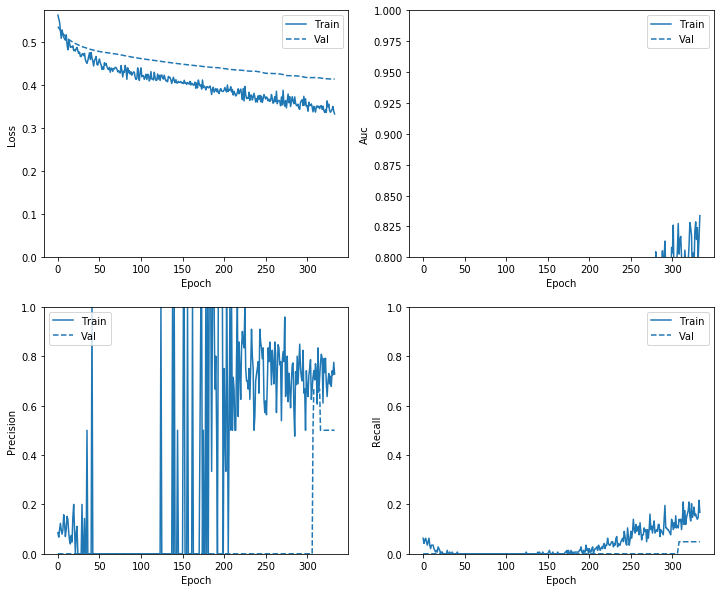

In [46]:
plot_metrics(baseline_history)

In [47]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [48]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sb.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Stayers Detected (True Negatives): ', cm[0][0])
  print('Leavers Incorrectly Detected (False Positives): ', cm[0][1])
  print('Stayers Missed (False Negatives): ', cm[1][0])
  print('Leavers Detected (True Positives): ', cm[1][1])
  #print('Total: ', np.sum(cm[1]))

loss :  0.3833027482032776
tp :  5.0
fp :  1.0
tn :  240.0
fn :  48.0
accuracy :  0.8333333
precision :  0.8333333
recall :  0.094339624
auc :  0.80310035

Stayers Detected (True Negatives):  240
Leavers Incorrectly Detected (False Positives):  1
Stayers Missed (False Negatives):  48
Leavers Detected (True Positives):  5


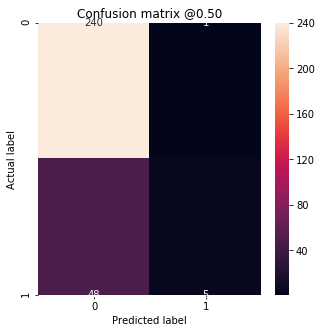

In [49]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [50]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

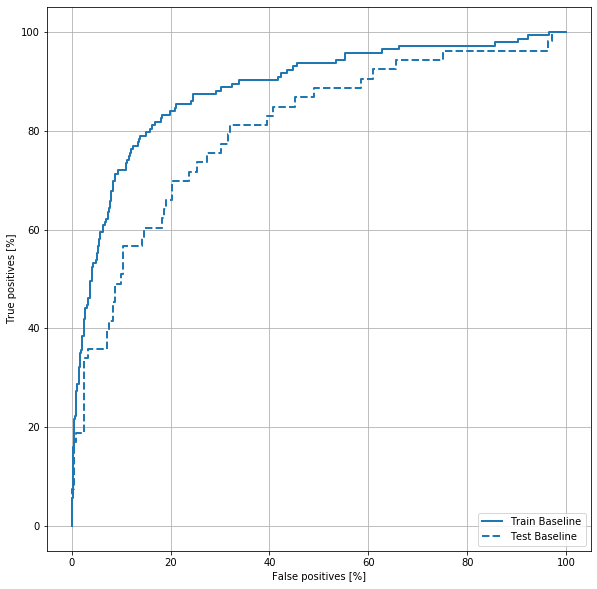

In [51]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [52]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 3.10


In [53]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Train on 940 samples, validate on 236 samples
Epoch 1/500
940/940 [==============================] - 1s 1ms/sample - loss: 0.8143 - tp: 13.0000 - fp: 89.0000 - tn: 708.0000 - fn: 130.0000 - accuracy: 0.7670 - precision: 0.1275 - recall: 0.0909 - auc: 0.4729 - val_loss: 0.5409 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 195.0000 - val_fn: 41.0000 - val_accuracy: 0.8263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3462
Epoch 2/500
940/940 [==============================] - 0s 26us/sample - loss: 0.8130 - tp: 9.0000 - fp: 90.0000 - tn: 707.0000 - fn: 134.0000 - accuracy: 0.7617 - precision: 0.0909 - recall: 0.0629 - auc: 0.4563 - val_loss: 0.5420 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 195.0000 - val_fn: 41.0000 - val_accuracy: 0.8263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3503
Epoch 3/500
940/940 [==============================] - 0s 21us/sample - loss: 0.8224 - tp: 11.0000 - fp: 91.0000 - tn: 706.0000 - fn: 132.0000 - a

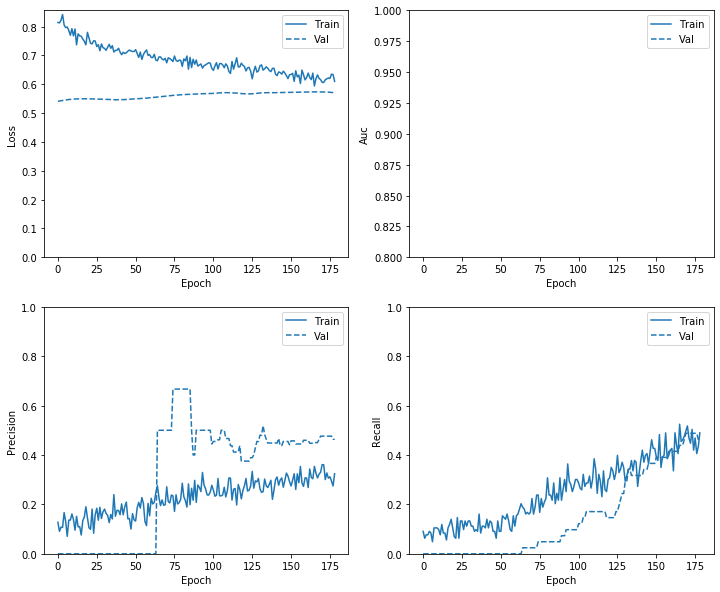

In [54]:
plot_metrics(weighted_history)

In [55]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.5737631320953369
tp :  28.0
fp :  42.0
tn :  199.0
fn :  25.0
accuracy :  0.77210885
precision :  0.4
recall :  0.5283019
auc :  0.7661865

Stayers Detected (True Negatives):  199
Leavers Incorrectly Detected (False Positives):  42
Stayers Missed (False Negatives):  25
Leavers Detected (True Positives):  28


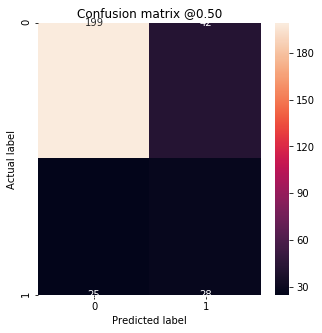

In [56]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

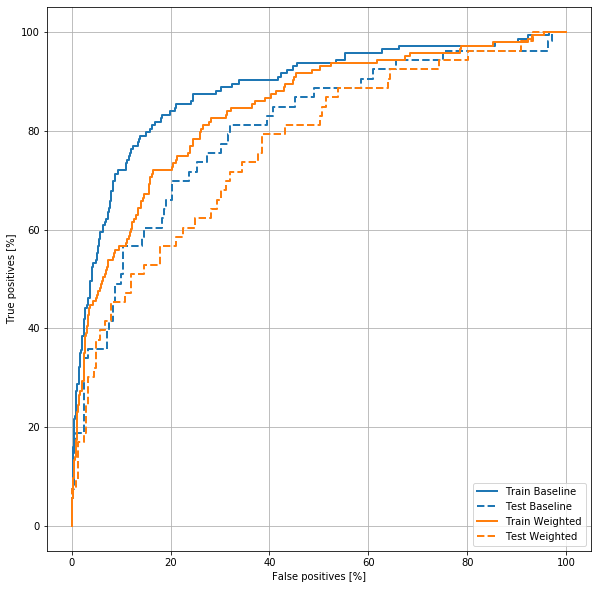

In [57]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [58]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [59]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(797, 45)

In [60]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(1594, 45)

In [61]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [62]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

2.0

In [63]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/500
2/2 [==============================] - 1s 687ms/step - loss: 0.8624 - tp: 144.0000 - fp: 212.0000 - tn: 1798.0000 - fn: 1942.0000 - accuracy: 0.4741 - precision: 0.4045 - recall: 0.0690 - auc: 0.4722 - val_loss: 0.5427 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 195.0000 - val_fn: 41.0000 - val_accuracy: 0.8263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3499
Epoch 2/500
2/2 [==============================] - 0s 28ms/step - loss: 0.8304 - tp: 178.0000 - fp: 218.0000 - tn: 1864.0000 - fn: 1836.0000 - accuracy: 0.4985 - precision: 0.4495 - recall: 0.0884 - auc: 0.4753 - val_loss: 0.5454 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 195.0000 - val_fn: 41.0000 - val_accuracy: 0.8263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3612
Epoch 3/500
2/2 [==============================] - 0s 28ms/step - loss: 0.8391 - tp: 184.0000 - fp: 254.0000 - tn: 1759.0000 - fn: 1899.0000 - accuracy: 0.4744 - precision: 0.4201 - recall: 0.0

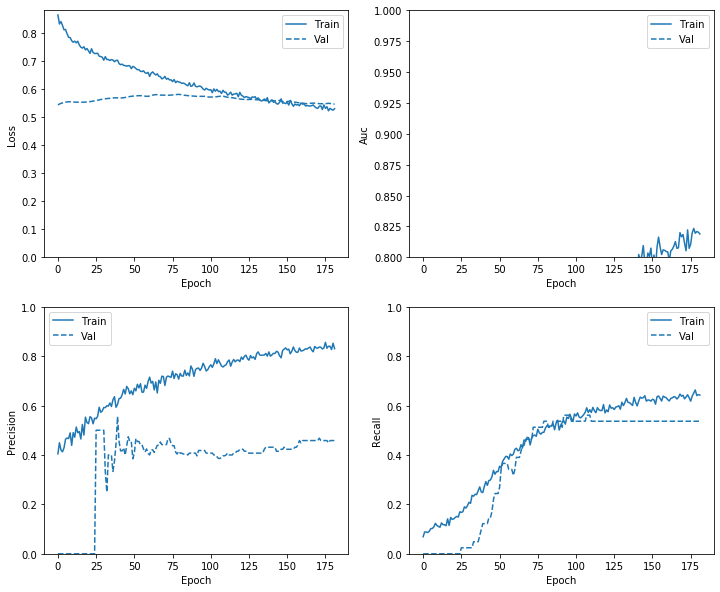

In [64]:
plot_metrics(resampled_history)

In [65]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Epoch 1/5000
20/20 [==============================] - 2s 101ms/step - loss: 0.8072 - tp: 1984.0000 - fp: 2428.0000 - tn: 18161.0000 - fn: 18387.0000 - accuracy: 0.4918 - precision: 0.4497 - recall: 0.0974 - auc: 0.4805 - val_loss: 0.5545 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 195.0000 - val_fn: 41.0000 - val_accuracy: 0.8263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4949
Epoch 2/5000
20/20 [==============================] - 1s 44ms/step - loss: 0.7501 - tp: 2518.0000 - fp: 2511.0000 - tn: 18108.0000 - fn: 17823.0000 - accuracy: 0.5036 - precision: 0.5007 - recall: 0.1238 - auc: 0.5101 - val_loss: 0.5546 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 195.0000 - val_fn: 41.0000 - val_accuracy: 0.8263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6124
Epoch 3/5000
20/20 [==============================] - 1s 40ms/step - loss: 0.7260 - tp: 3519.0000 - fp: 2741.0000 - tn: 17692.0000 - fn: 17008.0000 - accuracy: 0.5178 - precision:

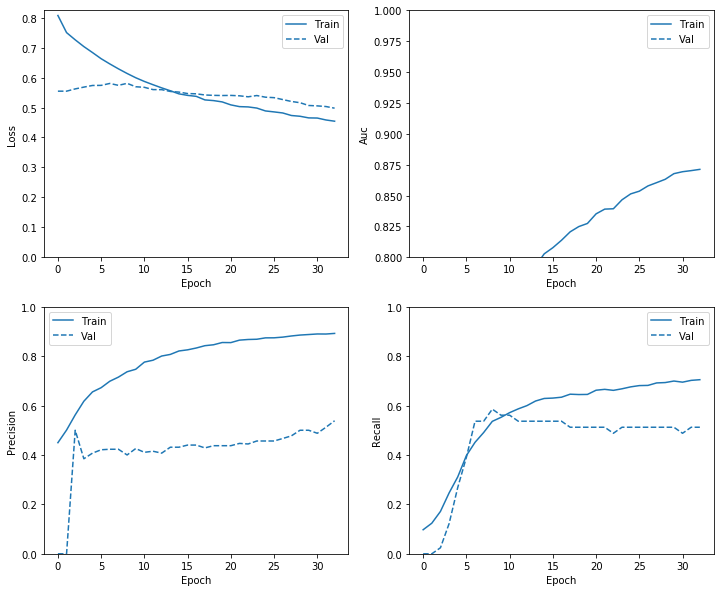

In [66]:
plot_metrics(resampled_history)

In [67]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.5344877243041992
tp :  35.0
fp :  37.0
tn :  204.0
fn :  18.0
accuracy :  0.81292516
precision :  0.4861111
recall :  0.6603774
auc :  0.80126023

Stayers Detected (True Negatives):  199
Leavers Incorrectly Detected (False Positives):  42
Stayers Missed (False Negatives):  25
Leavers Detected (True Positives):  28


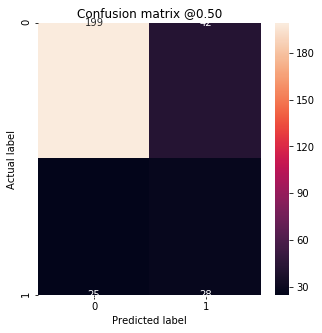

In [68]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

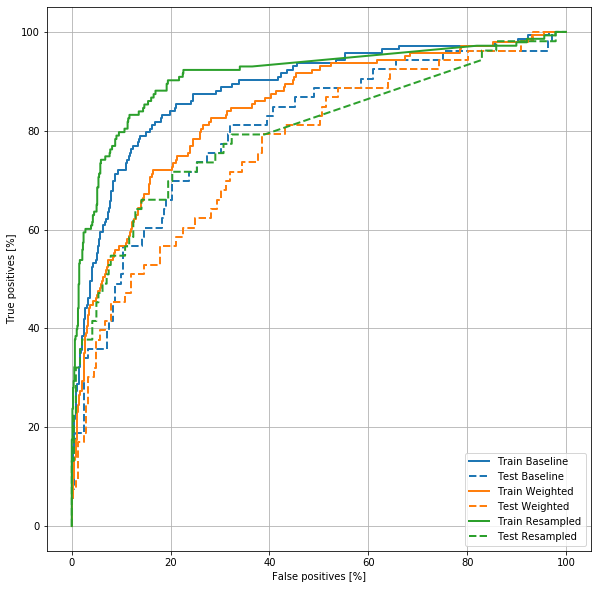

In [69]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')